# CNN-based Joint Model Notebook
---------------------------------------------
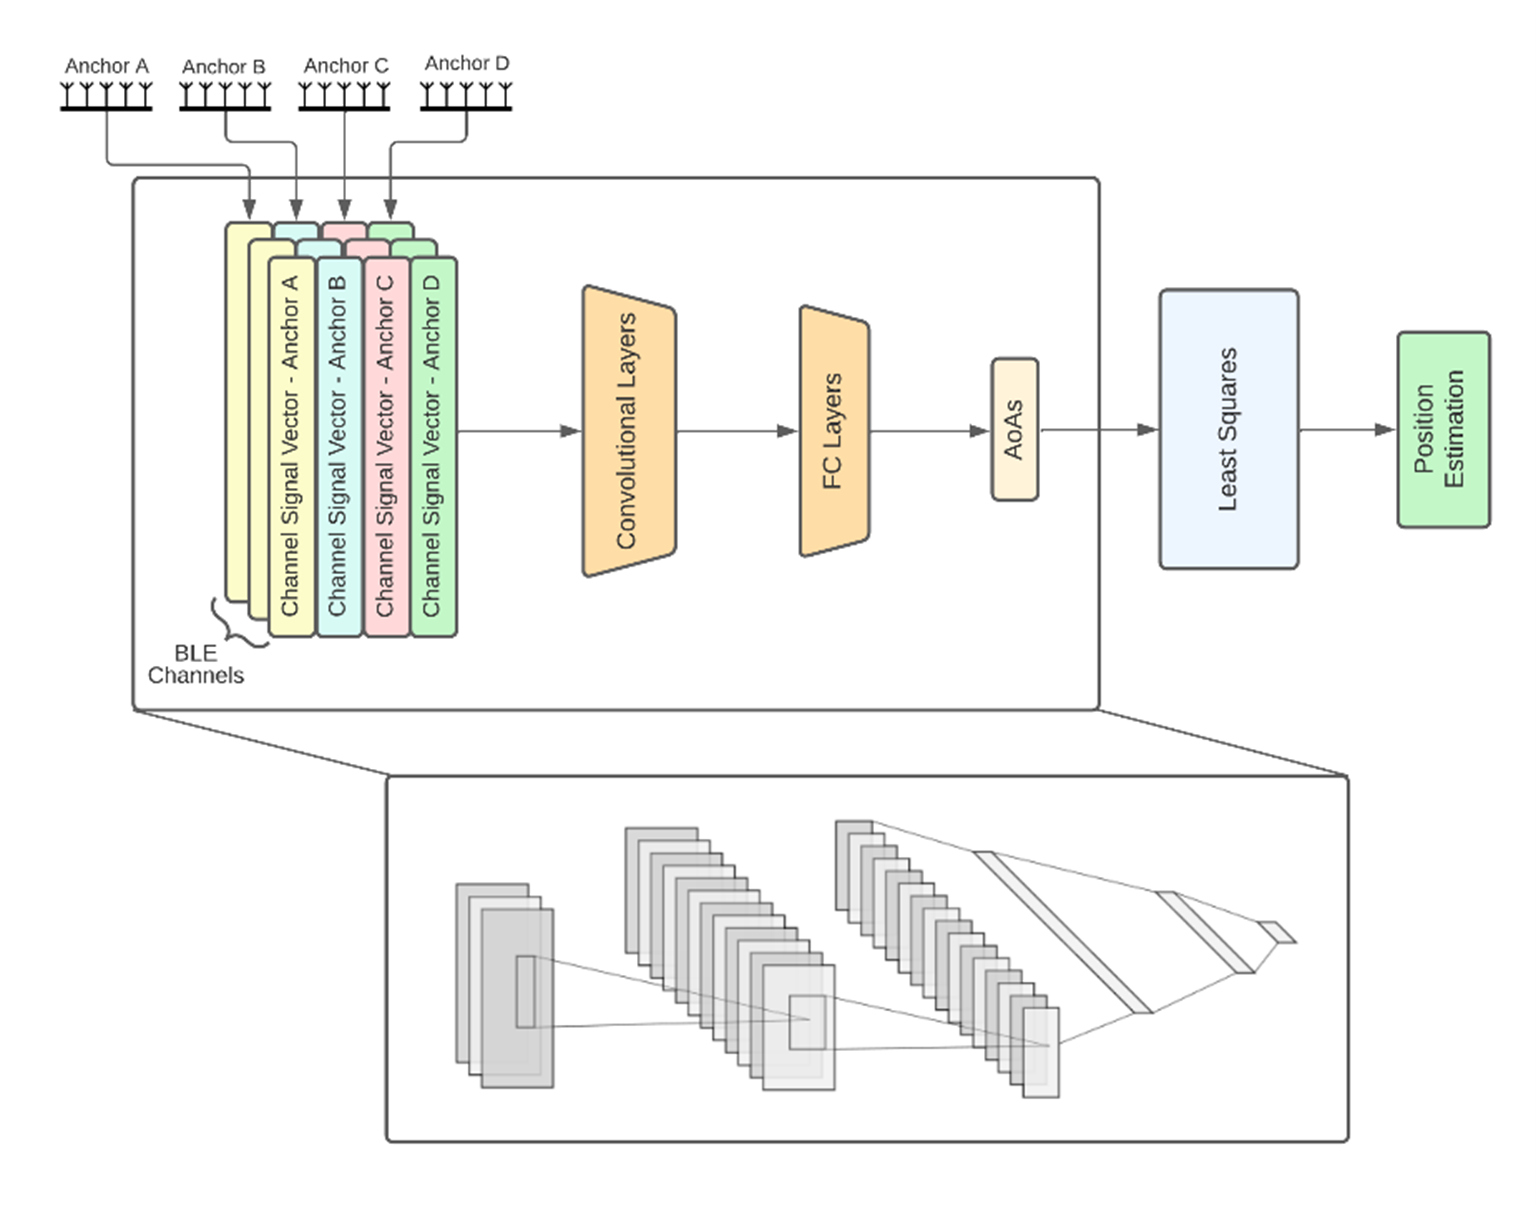

# Imports



In [ ]:
import pandas as pd
import numpy as np
import shutil
import os
from itertools import combinations

from collections import defaultdict
import json

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Input, callbacks
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import random
import copy

from functions import iq_processing, lsq, lsq_aux, create_set_cnn, create_iq_images, decreasing_signal, make_predictions, posHeatmapXY, default_to_regular, spatial_plot, addFurniture

# Dataset Import

In [ ]:
wd = '../..' #path to data (ADD YOUR PATH)

In [ ]:
#Import dataset
rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
concrete_rooms = ['testbench_01_furniture_low_concrete', 'testbench_01_furniture_mid_concrete', 'testbench_01_furniture_high_concrete']
other_scenarios = ['testbench_01_scenario2', 'testbench_01_scenario3']
anchors = ['anchor1', 'anchor2', 'anchor3', 'anchor4']
channels = ['37','38','39']
polarities = ['V','H']

data = defaultdict(lambda: defaultdict(lambda: defaultdict (lambda: defaultdict(list))))
anchor_data = defaultdict(lambda: defaultdict(lambda: defaultdict (lambda: defaultdict(list))))
for room in rooms + concrete_rooms + other_scenarios: 
    for channel in channels:  
        for polarity in polarities: 
             
            print(f'{wd}/data/{room}/tag_ml_export_CH{channel}_{polarity}.json')
            tag_filename = f'{wd}/data/{room}/tag_ml_export_CH{channel}_{polarity}.json'
            tag_df = pd.read_json(tag_filename, orient='records', lines = True)

            anchor_filename = f'{wd}/data/{room}/anchor_ml_export_CH{channel}_{polarity}.json'
            anchor_df = pd.read_json(anchor_filename, orient='records', lines = True)

            df = tag_df.merge(anchor_df)
            df.drop(df[(df['x_tag']==0).values | (df['y_tag']==0).values | (df['z_tag']==0).values].index, inplace=True)
            for anchor in anchors:
                data[room][anchor][channel][polarity] = df[df['anchor']==int(anchor[-1])]
                anchor_data[room][anchor][channel][polarity] = anchor_df

# Data Processing

In [ ]:
#Point sets creation
uniform_points = True
if uniform_points:

    points = data['testbench_01']['anchor1']['37']['H'].iloc[:, 1:7]

    # We use only the tag locations common in all rooms
    for room in rooms + concrete_rooms:
        for anchor in anchors:
            for channel in channels:
                for polarization in ['H','V']:
                    points = pd.merge(points, data[room][anchor][channel][polarization]['point'], on='point')
    
    xs = sorted(np.unique(points['x_tag']))[::6]
    ys = sorted(np.unique(points['y_tag']))[::3]
    train_points = points[points['x_tag'].isin(xs) & points['y_tag'].isin(ys)]
    
    xs = sorted(np.unique(points['x_tag']))[3::10]
    ys = sorted(np.unique(points['y_tag']))[3::10]
    val_points = points[points['x_tag'].isin(xs) & points['y_tag'].isin(ys)]

    test_points = points.drop(index=train_points.index).drop(index=val_points.index)

In [ ]:
print(f'Train Points No. : {len(train_points)}')
print(f'Val Points No. : {len(val_points)}')
print(f'Test Points No. : {len(test_points)}')

In [ ]:
plt.scatter(train_points.iloc[:,1:2].values,train_points.iloc[:,2:3].values)
plt.title('Training points')
plt.show()

We have 5 IQ measurements for each anchor-tag pair, one for each antenna of the anchor. We use the angle of the IQ-value of the first antenna element as reference for the rest of the antnnas. We also use the calculated RSSI value (signal strength) as feature for each anchor-tag pair.

The following are datasets that only use the polarization with the higher signal strength (RSSI) for each point.

In [ ]:
#Augmented train sets creation
train_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
x_train = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
y_train= defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for room in rooms + concrete_rooms + other_scenarios:
    for anchor in anchors:
        for channel in channels:
            for polarity in polarities:
                train_data[room][anchor][channel][polarity] = train_points[['point']].merge(data[room][anchor][channel][polarity], on='point')

tmp = defaultdict(lambda: defaultdict(dict))
y_tmp = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for room in rooms + concrete_rooms:
    for anchor in anchors:
        for channel in channels:
            h = train_data[room][anchor][channel]['H']
            v = train_data[room][anchor][channel]['V']
            m = h.where(h['relative_power']+h['reference_power'] > v['reference_power']+v['relative_power'], v)
            tmp[room][anchor][channel] = iq_processing(m).iloc[:,-10:]
        y_tmp[room][anchor] = train_data[room][anchor][channel]['H'][['true_phi', 'true_theta']]

x_reduced_signal_amp = []

for i in range(30):
    x_reduced_signal_amp.append(decreasing_signal(tmp, 5, rooms = rooms, anchors = anchors, channels = channels))

y_train = copy.deepcopy(y_tmp)

for room in rooms + concrete_rooms:
    for anchor in anchors:
        for channel in channels:
            for i in range(30):
                tmp[room][anchor][channel] = pd.concat([tmp[room][anchor][channel], x_reduced_signal_amp[i][room][anchor][channel]])
                
        for i in range(30):
            y_train[room][anchor] = pd.concat([y_train[room][anchor], y_tmp[room][anchor]])
            
    x_train[room]['iq_image'], x_train[room]['powers'] = create_iq_images(tmp[room], mode=mode, augm = True)

In [ ]:
#val and test sets creation
x_val, y_val = create_set_cnn(data, val_points, rooms = rooms, concrete_rooms = concrete_rooms, 
                              other_scenarios = other_scenarios, anchors = anchors, channels = channels)

x_test, y_test = create_set_cnn(data, test_points, rooms = rooms, concrete_rooms = concrete_rooms, 
                              other_scenarios = other_scenarios, anchors = anchors, channels = channels)

# CNN


## Model

In [ ]:
def cnn_model(lr = 0.001, conv_arch=[(12, (4,1), (1,1)), (16, (3,2), (1,1))], dense_arch=[[64,32], [0.1,0.1]], batch_norm=False):

    '''
    Input: Image of all the anchors and all their channels (10x4x3)
    Output: The 8 predicted Azimuthian and Elevation AoAs of the four anchors. 
    '''

    iq_input = Input((10,4,3), name='iq_image')
    power_input = Input(shape=(12,), name='powers') 

    x = iq_input
    for (num_channels, kernel, strides) in conv_arch: 
        if batch_norm == True:
            x = layers.BatchNormalization()(x)
        else:
            x = layers.Dropout(0.05)(x)
        x = layers.Conv2D(filters=num_channels, kernel_size=kernel, strides=strides, padding='valid', activation='relu')(x)

    p = layers.Dense(16)(power_input)
    p = layers.Dropout(0.1)(p)

    x = layers.Flatten()(x)
    x = layers.concatenate([x, p])
    for i in range(len(dense_arch[0])):
        x = layers.Dense(dense_arch[0][i], activation='relu')(x)
        x = layers.Dropout(dense_arch[1][i])(x)

    out = layers.Dense(8)(x)

    model = tf.keras.Model(
        inputs=[iq_input, power_input],
        outputs=out,
    )

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mse', metrics = 'mae')

    return model

In [ ]:
cnn_model().summary()

## Optimizing

In [ ]:
#Train parameters
fit_params = {'batch_size': 128, 'validation_batch_size':32, 'epochs': 1500, 'verbose': 1,
              'callbacks': [callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=0, patience=75, restore_best_weights=True)]}

In [ ]:
#Model training
load = False

if load:
    cnn_anchor_models = defaultdict(lambda: cnn_model(0.0005))
    for room in rooms:
        cnn_anchor_models[room] = models.load_model(f'/path_to_model/cnn_model/{room}') #add your path

else:
    cnn_anchor_models = defaultdict(lambda: cnn_model(0.0005))
    for training_room in rooms:

        print(training_room)
        cnn_anchor_models[training_room] = cnn_model(0.0005)

        ytrain = pd.concat([y_train[training_room][anchor] for anchor in anchors], axis=1)
        yval = pd.concat([y_val[training_room][anchor] for anchor in anchors], axis=1)

        cnn_anchor_models[training_room].fit(x_train[training_room], ytrain,
                                    validation_data=(x_val[training_room], yval), 
                                    **fit_params)

In [ ]:
#You can save the model
save =  False

if save:
    for room in rooms:
        cnn_anchor_models[room].save(f'/path_to_model/cnn_model/{room}') #add your path

## Predictions

In [ ]:
#Make predictions
preds, true_pos = make_predictions(x_test, y_test, cnn_anchor_models, rooms = rooms, concrete_rooms = concrete_rooms, test_points = test_points,
                                   other_scenarios = other_scenarios, anchors = anchors, anchor_data = anchor_data)

pos_preds_cnn = preds['pos_preds']
pos_maes_cnn = preds['pos_maes']

In [ ]:
#You can save your predictions
save_preds = False
if save_preds:
    results_path = f'/path_to_preds/cnn_preds.npy' #add your path
    np.save(results_path, default_to_regular(preds))

In [ ]:
#You can load your predictions
load_preds = False
if load_preds:
    preds = np.load(f'/path_to_preds/cnn_preds.npy', allow_pickle=True)[()] #add your path

## Results

In [ ]:
#show heatmap
posHeatmapXY(pos_preds_cnn[:,:7], scenarios = False)
plt.xlabel('\n\n CNN-based Joint Model with Augmentation Distance Error(m)')
plt.show()

In [ ]:
#show spatial error plot
spatial_plot(pos_maes_cnn['testbench_01_furniture_low']['testbench_01_furniture_high'], true_pos, testing_room = 'testbench_01_furniture_high', mode = 'xy',vmax = 3, cmap = 'YlOrRd')
plt.xlabel('x (m) \n\n CNN-based Joint Model Distance Error (m)')
plt.ylabel('MEDE (m)')
plt.show()